# Analysis and plotting of RBD depletion ELISA data for HAARVI serum project

I used commercially-available magnetic beads conjugated to SARS-CoV-2 RBD to deplete serum of RBD-binding antibodies. 
Control pre-pandemic serum spiked with either an RBD-binding monoclonal antibody, rREGN10987 (at 5, 25, or 50 ug/mL) or an NTD-binding antibody (at 50 ug/mL) were also incubated with the RBD beads to get an estimate of how well the depletion works. 

The process of pulling down the RBD antibodies involved diluting the serum 1:4 (because I added 50 uL serum + 150 uL of bead suspension at 1mg/mL). 
In one condition that we will not plot here, I used 2x as many beads, and thus added 50 uL serum + 300 uL of bead suspension, so this was a 1:7 dilution of the initial serum.

The pre-depletion serum was also diluted 1:4 (or 1:7, as appropriate) in PBS + 0.05% BSA (the buffer the beads were suspended in). 

Depletions were performed overnight at 4C in Eppendorf tubes in a tube rotator. 

SARS-CoV-2 RBD and spike ELISAs were performed on these samples to verify the degree of RBD antibody depletion.

Here, I calculate the AUC for pre- vs. post-depletion samples and the fold-change in AUC. 

This is really just a test of whether the depletion worked at all and I don't think it is very useful for anything beyond that (see notes at the end!).

Andrea Loes and I (Allie Greaney) then performed neutralization assays on these samples. 
We started each sample at a slightly different initial dilution to capture the full neutralization curve for each sample, given that each serum has a different neutralization potency (determined in Kate's original paper).

The data that are analyzed in this notebook were pre-processed by Kate's `excel_to_fracinfect` script. 

### Set up Analysis

Import packages.

In [1]:
import itertools
import math
import os
import re
import warnings

from IPython.display import display, HTML

import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt
from mizani.formatters import scientific_format

import numpy as np
import pandas as pd
from plotnine import *
import seaborn

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
import seaborn

import sklearn
import scipy.stats

import yaml

In [2]:
warnings.simplefilter('ignore')

Read config file.

In [3]:
with open('rbd_absorption_config.yaml') as f:
    config = yaml.safe_load(f)

Use seaborn theme and change font:

In [4]:
theme_set(theme_seaborn(style='white', context='talk', font='FreeSans', font_scale=1))
plt.style.use('seaborn-white')

In [5]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

In [6]:
pd.options.display.max_rows = 100

## Read in sample information

In [7]:
sample_information = pd.read_csv(config['sample_information'],
                                 dtype={'Days Post-Symptom Onset': float})

published_metadata = (pd.read_csv(config['published_metadata'],
                                  dtype={'Days Post-Symptom Onset': float},
                                  index_col=0)
                      .rename(columns={"IC50": "IC50_D614", "NT50": "NT50_D614"})
                 )

## Neutralization Assays

### Read in data
* Concatenate the `frac_infectivity` files.
* Remove samples specified in config file. 
* Also remove specified sample / dilution combinations where something has clearly gone wrong experimentally (like forgetting to add virus or cells). 
* Replace `serum` with `display_name`

In [8]:
frac_infect = pd.DataFrame() # create empty data frame
neut_samples_ignore = config['neut_samples_ignore']

for f in config['neut_input_files'].keys():
    df = (pd.read_csv(f, index_col=0).assign(date=config['neut_input_files'][f]))
    frac_infect = frac_infect.append(df).reset_index(drop=True)

print(f"Length before dropping anything = {len(frac_infect.index)}")
    
frac_infect = (frac_infect
        .query('serum not in @neut_samples_ignore')
        #.replace({'serum' : config['display_names']})
        .reset_index(drop=True)
       )

print(f"Length after dropping neut_samples_ignore = {len(frac_infect.index)}")

for s in config['neut_ignore_dilutions']:
    dil = config['neut_ignore_dilutions'][s]
    l = len((frac_infect[(frac_infect['serum'] == s) & (frac_infect['concentration'] == dil)]))
    print(f"Dropping {l} rows")
    frac_infect = frac_infect.drop(frac_infect[((frac_infect['serum'] == s) & (frac_infect['concentration'] == dil))].index)
    print(f"Length after dropping {s}: {dil} = {len(frac_infect.index)}")

for s in config['neut_ignore_dates']:
    dat = config['neut_ignore_dates'][s]
    l = len((frac_infect[(frac_infect['serum'] == s) & (frac_infect['date'] == dat)]))
    print(f"Dropping {l} rows")
    frac_infect = frac_infect.drop(frac_infect[((frac_infect['serum'] == s) & (frac_infect['date'] == dat))].index)
    print(f"Length after dropping {s}: {dil} = {len(frac_infect.index)}")

frac_infect = (frac_infect
               .merge(sample_information, left_on='serum', right_on='sample_name')
               .drop(columns=['serum'])
               .assign(serum=lambda x: x['display_name'])
              )
frac_infect.head(2)

Length before dropping anything = 1302
Length after dropping neut_samples_ignore = 1218
Dropping 4 rows
Length after dropping 23C_d26: 0.000205761 = 1214
Dropping 4 rows
Length after dropping 23C_d102: 0.000205761 = 1210
Dropping 28 rows
Length after dropping 24C_d32: 0.000205761 = 1182
Dropping 28 rows
Length after dropping 24C_d104: 0.000205761 = 1154
Dropping 28 rows
Length after dropping 1C_d26: 0.000205761 = 1126


,virus,replicate,concentration,fraction infectivity,date,Unnamed: 6,sample,Participant ID,Days Post-Symptom Onset,sample_name,display_PID,display_name,depletion_elisas,depletion_neuts,sample_group,mapped,experiment,serum
0,pre-depletion,1,0.016667,0.096030,201012,NaN,191A5833,13,15.0,13_d15,subject J,subject J (day 15),True,True,serum,True,expt_31,subject J (day 15)
1,pre-depletion,1,0.005556,0.201285,201012,NaN,191A5833,13,15.0,13_d15,subject J,subject J (day 15),True,True,serum,True,expt_31,subject J (day 15)


### Fit Hill curve to data using [`neutcurve`](https://jbloomlab.github.io/neutcurve/)
* Then pivot table, grouping by `serum` and keeping the `serum` and `ic50` columns
* Calculate fold-change ic50 post-depletion vs. pre-depletion
* Take fits.fitParams and drop all the pre-depletion samples 
* Keep `ic50_bound` and merge with fold_change

In [9]:
fits = neutcurve.CurveFits(frac_infect)

fitparams = (
    fits.fitParams()
    .rename(columns={'virus': 'depletion'})
    # get columns of interest
    [['serum', 'depletion', 'ic50', 'ic50_bound']]
    .assign(NT50=lambda x: 1/x['ic50'])
    .merge(sample_information, left_on='serum', right_on='display_name')
    )

# couldn't get lambda / conditional statement to work with assign, so try it here:
fitparams['ic50_is_bound'] = fitparams['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)

fitparams.head(2)

,serum,depletion,ic50,ic50_bound,NT50,sample,Participant ID,Days Post-Symptom Onset,sample_name,display_PID,display_name,depletion_elisas,depletion_neuts,sample_group,mapped,experiment,ic50_is_bound
0,subject J (day 15),pre-depletion,0.001638,interpolated,610.352369,191A5833,13,15.0,13_d15,subject J,subject J (day 15),True,True,serum,True,expt_31,False
1,subject J (day 15),post-depletion,0.006011,interpolated,166.360761,191A5833,13,15.0,13_d15,subject J,subject J (day 15),True,True,serum,True,expt_31,False


### Make horizontal line plot connecting pre- and post-IC50
* Order with greatest fold-change at the top
* Put labels on far right with the % of neutralizing activity targeting the RBD (percent_RBD = 1-(1/foldchange))
* color by pre vs post
* shape is censored
* vertical line for limit of detection

In [10]:
foldchange = (
    fitparams
    .query('serum!="pre-pandemic"')
    .pivot_table(values='ic50', index=['serum'], columns=['depletion'])
    .reset_index()
    .rename(columns={'post-depletion': 'post-depletion_ic50', 'pre-depletion': 'pre-depletion_ic50'})
    .assign(fold_change=lambda x: x['post-depletion_ic50'] / x['pre-depletion_ic50'],
            percent_RBD= lambda x: ((1-1/x['fold_change'])*100).astype(int),
            NT50_pre=lambda x: 1/x['pre-depletion_ic50'],
            NT50_post=lambda x: 1/x['post-depletion_ic50'],
           )
    .merge(fitparams.query('depletion=="post-depletion"')[['serum', 'ic50_is_bound']], on='serum')
    .assign(perc_RBD_str = lambda x: x['percent_RBD'].astype(str)
           )
    .rename(columns={'ic50_is_bound': 'post_ic50_bound'})
    .merge(fitparams)
    # merge with published metadata but we don't need the old ELISA data because it's not very reliable
    .merge(published_metadata.drop(columns=['RBD IgA', 'RBD IgG', 'RBD IgM', 'Spike IgG']), 
           how='left', 
           on=['sample', 'Participant ID', 'Days Post-Symptom Onset']
          )
    .assign(logNT50_D614 = lambda x: np.log(x.NT50_D614),
            logNT50_G614 = lambda x: np.log(x.NT50_pre))
    )

foldchange['perc_RBD_str'] = np.where(foldchange['post_ic50_bound'], '>'+foldchange['perc_RBD_str']+'%', foldchange['perc_RBD_str']+'%')

foldchange=(foldchange.merge((foldchange
              [['Participant ID', 'serum', 'fold_change']]
              .groupby('Participant ID')
              .aggregate({'fold_change' : 'max'})
              .reset_index()
              .drop_duplicates()
              .rename(columns={'fold_change':'max_fc'})
             ), 
            how='left', 
            on='Participant ID'
           ))

serum_order = foldchange.query('sample_group=="serum"').sort_values(['max_fc', 'fold_change'], ascending=True)['display_name'].unique()
PID_order= foldchange.query('sample_group=="serum"').sort_values(['max_fc', 'fold_change'], ascending=False)['display_PID'].unique()
print(PID_order)
foldchange.head(2)

['subject C' 'subject A' 'subject G' 'subject E' 'subject J' 'subject K'
 'subject B' 'subject L' 'subject I' 'subject P' 'subject F' 'subject Q'
 'subject R' 'subject M' 'subject D' 'subject H' 'subject N']


,serum,post-depletion_ic50,pre-depletion_ic50,fold_change,percent_RBD,NT50_pre,NT50_post,post_ic50_bound,perc_RBD_str,depletion,...,experiment,ic50_is_bound,Sex,Age,Severity,IC50_D614,NT50_D614,logNT50_D614,logNT50_G614,max_fc
0,r4A8 (50ug/mL),0.000069,0.000132,0.519645,-92,7576.430381,14580.001196,True,>-92%,pre-depletion,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,8.932797,NaN
1,r4A8 (50ug/mL),0.000069,0.000132,0.519645,-92,7576.430381,14580.001196,True,>-92%,post-depletion,...,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,8.932797,NaN


### Plot fold-change NT50 pre- and post-RBD antibody depletion for the serum samples only 
Exclude pre-pandemic serum, which was not depleted.

In [11]:
df = (foldchange.query('sample_group=="serum"'))
df=(df
      .assign(serum= pd.Categorical(df['serum'], categories=serum_order, ordered=True),
              display_PID= pd.Categorical(df['display_PID'], categories=PID_order, ordered=True)
             )
      .replace({'pre-depletion': 'pre', 'post-depletion': 'post'})
     )
df['fill_color'] = 'pre-depletion'
df.loc[df.mapped == True, 'fill_color'] = 'escape mapped'
df['fill_color'] = np.where(df['depletion'] == 'post', 'post-depletion', df['fill_color'])

df['depletion']=pd.Categorical(df['depletion'], categories=['pre', 'post'], ordered=True)

nconditions = df['serum'].nunique()

df = df.sort_values(by=['serum', 'depletion'])

#df=df[['serum', 'display_name', 'depletion', 'NT50', 'fold_change', 'fill_color', 'mapped','perc_RBD_str']]

df.columns

Index(['serum', 'post-depletion_ic50', 'pre-depletion_ic50', 'fold_change',
       'percent_RBD', 'NT50_pre', 'NT50_post', 'post_ic50_bound',
       'perc_RBD_str', 'depletion', 'ic50', 'ic50_bound', 'NT50', 'sample',
       'Participant ID', 'Days Post-Symptom Onset', 'sample_name',
       'display_PID', 'display_name', 'depletion_elisas', 'depletion_neuts',
       'sample_group', 'mapped', 'experiment', 'ic50_is_bound', 'Sex', 'Age',
       'Severity', 'IC50_D614', 'NT50_D614', 'logNT50_D614', 'logNT50_G614',
       'max_fc', 'fill_color'],
      dtype='object')

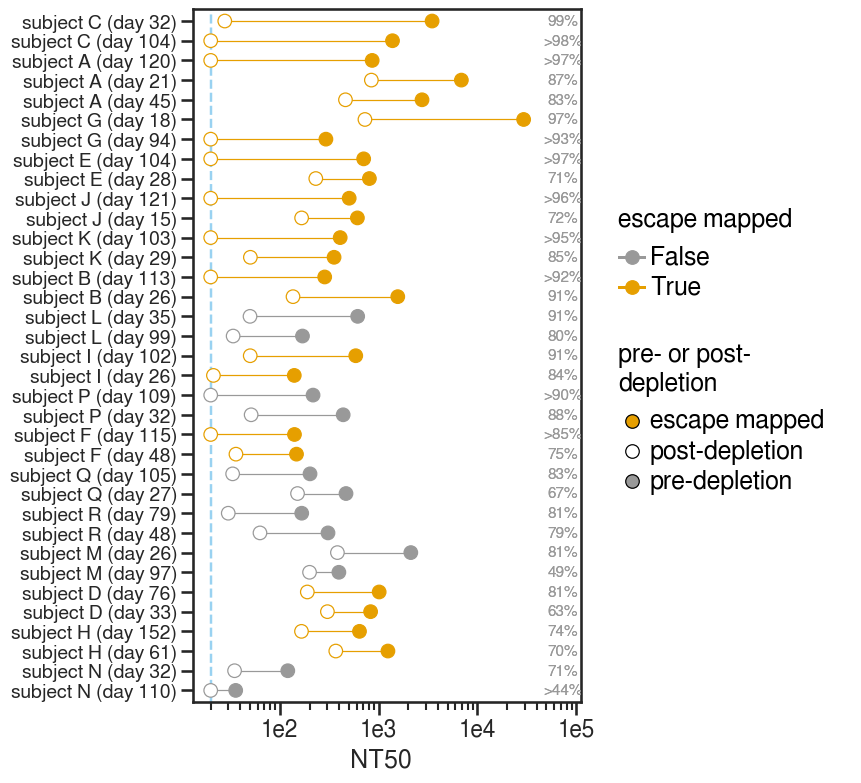

In [12]:
p = (ggplot(df, aes(x='NT50',
                    y='serum',
                    color='mapped',
                    fill='fill_color', 
                    group='serum',
                    label='perc_RBD_str'
                   )) +
     scale_x_log10(name='NT50') +
     geom_vline(xintercept=config['NT50_LOD'], 
                linetype='dashed', 
                size=1, 
                alpha=0.6, 
                color=CBPALETTE[2]) +
     geom_line(alpha=1) +
     geom_point(size=5) +
     geom_text(aes(x=df['NT50'].max()*2.5, y='serum'),
               color=CBPALETTE[0],
              ) +
     ylab('') +
     theme(figure_size=(5,9),
           axis_text_y=element_text(size=14),
          ) +
     scale_color_manual(values=CBPALETTE, name='escape mapped') +
     scale_fill_manual(values=['#E69F00', '#FFFFFF', '#999999'], name='pre- or post-\ndepletion')
                )

_ = p.draw()

for filetype in ['svg', 'pdf', 'png']:
    p.save(f'{resultsdir}/NT50_lineplot.{filetype}')

#### Also make as a segment plot in case that ends up being useful some day / some way.

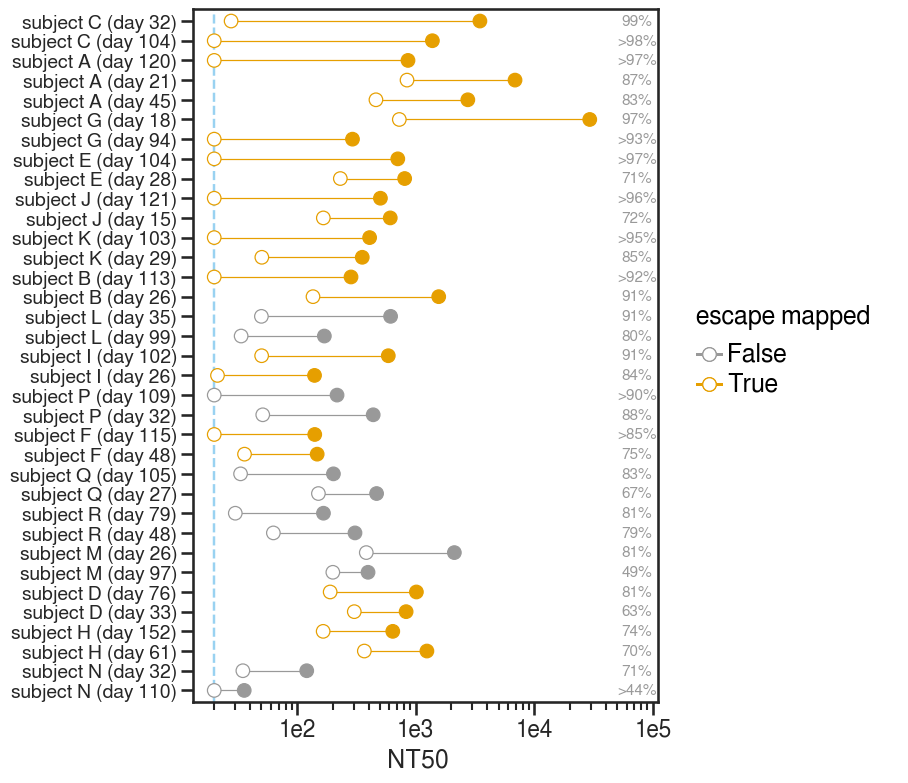

In [13]:
p = (ggplot(df[['serum', 'NT50_pre', 'NT50_post', 
       'perc_RBD_str', 'mapped', 'max_fc',]].drop_duplicates(),
            aes(
                color='mapped',
                label='perc_RBD_str'
                   )) +
     scale_x_log10(name='NT50') +
     geom_vline(xintercept=config['NT50_LOD'], 
                linetype='dashed', 
                size=1, 
                alpha=0.6, 
                color=CBPALETTE[2]) +
     geom_segment(aes(x='NT50_pre', y='serum', xend='NT50_post', yend='serum'), alpha=1) +
     geom_point(aes(x='NT50_pre', y='serum'), size=5) +
     geom_point(aes(x='NT50_post', y='serum'), size=5, fill='white') +
     geom_text(aes(x=df['NT50'].max()*2.5, y='serum'),
               color=CBPALETTE[0],
               #size=9
              ) +
     ylab('') +
     theme(figure_size=(6,9),
           axis_text_y=element_text(size=14),
          ) 
     +
     scale_color_manual(values=CBPALETTE, name='escape mapped') 
                )

_ = p.draw()


p.save(f'{resultsdir}/NT50_segmentplot.pdf')

### Look at fold-change NT50 at the early and late timepoints to see how RBD targeting changes over time.

In [14]:
df.columns

Index(['serum', 'post-depletion_ic50', 'pre-depletion_ic50', 'fold_change',
       'percent_RBD', 'NT50_pre', 'NT50_post', 'post_ic50_bound',
       'perc_RBD_str', 'depletion', 'ic50', 'ic50_bound', 'NT50', 'sample',
       'Participant ID', 'Days Post-Symptom Onset', 'sample_name',
       'display_PID', 'display_name', 'depletion_elisas', 'depletion_neuts',
       'sample_group', 'mapped', 'experiment', 'ic50_is_bound', 'Sex', 'Age',
       'Severity', 'IC50_D614', 'NT50_D614', 'logNT50_D614', 'logNT50_G614',
       'max_fc', 'fill_color'],
      dtype='object')

Saving to results/rbd_absorptions/depletion_overtime_facet.svg
Saving to results/rbd_absorptions/depletion_overtime_facet.pdf
Saving to results/rbd_absorptions/depletion_overtime_facet.png


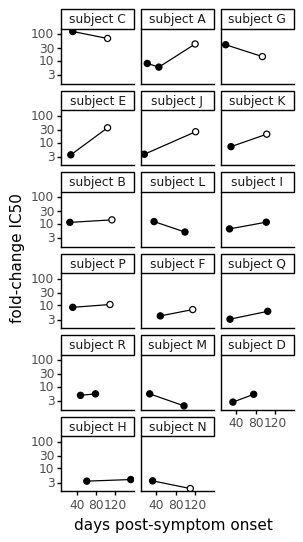

In [15]:
nconditions = foldchange.query('sample_group=="serum"')['serum'].nunique()
ncol = 3 if nconditions >= 3 else nconditions
nrow = math.ceil(nconditions / ncol)

p = (ggplot(df
            .query('sample_group=="serum"')
            [['display_PID', 'Days Post-Symptom Onset', 'fold_change', 'post_ic50_bound']]
            .drop_duplicates()
           ) +
     aes('Days Post-Symptom Onset', 'fold_change', group='display_PID', fill='post_ic50_bound') +
     geom_line(aes(group='display_PID'), size=0.5) +
     geom_point(size=2, alpha=1) +
     scale_y_log10() +
     facet_wrap('~ display_PID', ncol=ncol) +
     theme_classic() +
     theme(
           figure_size=(1 * ncol, 0.5 * nrow),
           ) +
     xlab('days post-symptom onset') +
     ylab('fold-change IC50') +
     labs(fill='censored') +
     scale_fill_manual(values=['black', 'white'], guide=False)
     )

_ = p.draw()

for filetype in ['svg', 'pdf', 'png']:
    plotfile = f'{resultsdir}/depletion_overtime_facet.{filetype}'
    print(f"Saving to {plotfile}")
    p.save(plotfile, verbose=False)

This is great! 
We can see that for several samples, the fold-change in IC50 is even greater than was observed for the monoclonal antibody, rREGN10987. 
Our fold-change is limited by two factors:
1. The IC50 of the pre-depletion sample (the more potent the pre-depletion IC50, the greater magnitude of change we are able to detect)
2. The dilutions used on the post-depletion sample, which determine the bounds or upper limit of IC50 that can be calculated.

For a number of samples, our post-depletion IC50 is bound because `neutcurve` is unable to determine an IC50 with the dilutions we used. 
So, do keep this in mind when interpreting the fold-change IC50.
However -- the max fold-change we are able to detect is related to the potency of the pre-depletion serum, and we probably want to be using the *most potent sera* that are *the most RBD-targeting* so I think we can still find these bounded numbers as useful. 

## Plot neut curves for all samples
First, plot for the 3 rREGN10987 antibodies.
We will not plot with 4A8 because this antibody behaves strangely / may not be neutralizing in our 293T-ACE2 PV neut assays, so the ELISA data are much more useful.

In [16]:
REGN_mabs = (foldchange
 .query('sample_group=="antibody_control" & serum!="r4A8 (50ug/mL)"')
 .assign(serum=pd.Categorical(foldchange.query('sample_group=="antibody_control" & serum!="r4A8 (50ug/mL)"')['serum'], 
                              categories=['rREGN10987 (50ug/mL)', 
                                          'rREGN10987 (25ug/mL)', 
                                          'rREGN10987 (5ug/mL)'], 
                              ordered=True)
        )
 ['serum']
 .sort_values()
 .unique()
 .tolist()
)
print(REGN_mabs)

['rREGN10987 (50ug/mL)', 'rREGN10987 (25ug/mL)', 'rREGN10987 (5ug/mL)']


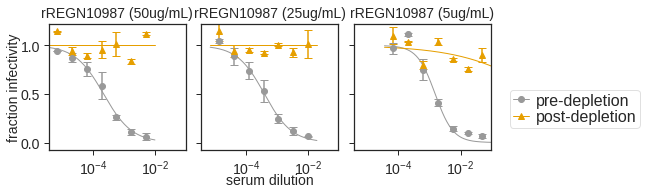

In [17]:
fig, axes = fits.plotSera(sera=REGN_mabs,
                          xlabel='serum dilution',
                          ncol=3,
                          widthscale=0.75,
                          heightscale=1,
                          titlesize=14, labelsize=14, ticksize=14, legendfontsize=16, yticklocs=[0,0.5,1]
                         )

plotfile = PdfPages(f'{resultsdir}/REGN_frac_infectivity.pdf')
plotfile.savefig(bbox_inches='tight', transparent=True)
plotfile.close()

In [18]:
# the original list is in backwards order for making the previous plots 
print(serum_order.tolist()[::-1]+['pre-pandemic'])

['subject C (day 32)', 'subject C (day 104)', 'subject A (day 120)', 'subject A (day 21)', 'subject A (day 45)', 'subject G (day 18)', 'subject G (day 94)', 'subject E (day 104)', 'subject E (day 28)', 'subject J (day 121)', 'subject J (day 15)', 'subject K (day 103)', 'subject K (day 29)', 'subject B (day 113)', 'subject B (day 26)', 'subject L (day 35)', 'subject L (day 99)', 'subject I (day 102)', 'subject I (day 26)', 'subject P (day 109)', 'subject P (day 32)', 'subject F (day 115)', 'subject F (day 48)', 'subject Q (day 105)', 'subject Q (day 27)', 'subject R (day 79)', 'subject R (day 48)', 'subject M (day 26)', 'subject M (day 97)', 'subject D (day 76)', 'subject D (day 33)', 'subject H (day 152)', 'subject H (day 61)', 'subject N (day 32)', 'subject N (day 110)', 'pre-pandemic']


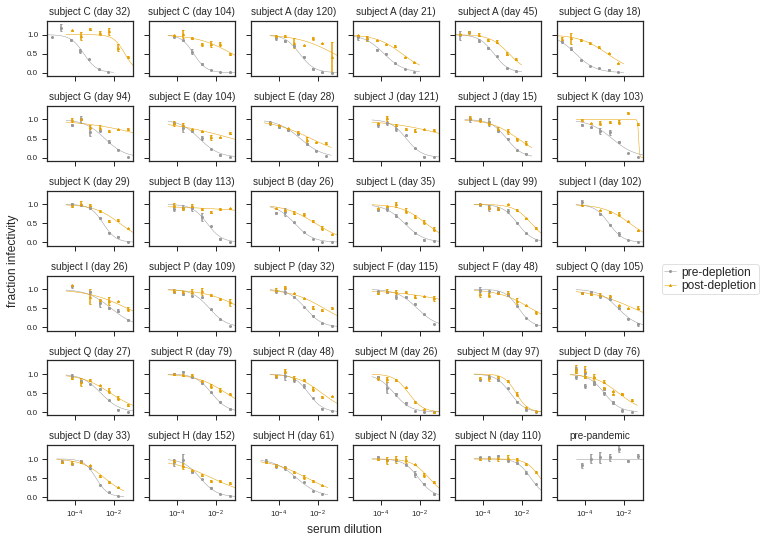

In [19]:
fig, axes = fits.plotSera(sera=serum_order.tolist()[::-1]+['pre-pandemic'],
                          xlabel='serum dilution',
                          ncol=6,
                          widthscale=0.5,
                          heightscale=0.55,
                          titlesize=10, labelsize=12, ticksize=8, legendfontsize=12, yticklocs=[0,0.5,1],
                          markersize=2, linewidth=0.5,
                         )

plotfile = PdfPages(f'{resultsdir}/sera_frac_infectivity.pdf')
plotfile.savefig(bbox_inches='tight', transparent=True)
plotfile.close()

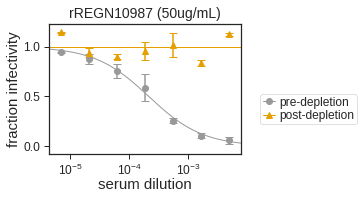

In [20]:
fig, axes = fits.plotSera(sera=['rREGN10987 (50ug/mL)'],
                          xlabel='serum dilution',
                         )

plotfile = PdfPages(f'{resultsdir}/REGN50_frac_infectivity.pdf')
plotfile.savefig(bbox_inches='tight', transparent=True)
plotfile.close()

### Compare pre-depletion IC50s to [Kate's published data](https://academic.oup.com/jid/advance-article/doi/10.1093/infdis/jiaa618/5916372)

First read in [Supplementary File 2](https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/jid/PAP/10.1093_infdis_jiaa618/1/jiaa618_suppl_supplementary_files_2.xlsx?Expires=1607057702&Signature=y8OMaiRqv333yv75g3X1SlHt9p-c98RXQvIm-q8ZmNaDlTHIIVlhoD8L1NXt8mWwDvEfFioxsoVpArW60VQ4mjPV-Qmu7O5N9-eKnnFeBincOg1fKxBBkzAe1TeT2NtqnAXFTEcZD30~Kt4UwViVxZUH8SMn4NuStwRREfG6C23TWTDTMLr9tlISxVZW65Cz0vK0hbhLv~3mC8IXes6mUh6VrHVDdSTmUBk0SN4Dhv6gLcMEmltdVHRgBFuuLFTq-VPRm7z43XV1FYiorDDrS6nmqihYtSQNV6sdbA2obqKDHt3xEcOK-ln~vtLcT0-FQ94p-1lFkf4h8-ebGrzLQw__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA). 
Then merge with our new data. 
Plot Kate's vs. Andrea's IC50s (Andrea's are done with D614G, but Kate's were done with D614).

In [21]:
corr, _ = scipy.stats.pearsonr(foldchange.dropna(subset=['sample'])['logNT50_D614'], foldchange.dropna(subset=['sample'])['logNT50_G614'])
print(f'Pearsons correlation: {corr}'.format())

Pearsons correlation: 0.8755792729320928


Saving to ./results/rbd_absorptions/D614vG614_NT50.svg
Saving to ./results/rbd_absorptions/D614vG614_NT50.pdf
Saving to ./results/rbd_absorptions/D614vG614_NT50.png


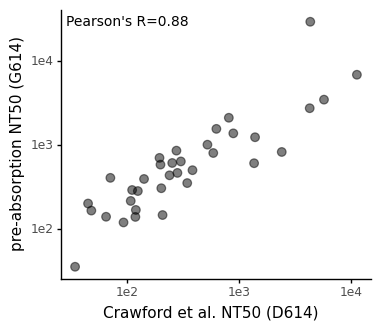

In [22]:
p = (ggplot((foldchange
             .dropna(subset=['sample'])
             [['serum', 'display_PID', 'NT50_D614', 'NT50_pre']]
             .drop_duplicates()
            )
           ) +
     aes('NT50_D614', 'NT50_pre', label='display_PID') +
     geom_point(size=3, alpha=0.5) +
     scale_x_log10() +
     scale_y_log10() +
     theme_classic() +
     theme(figure_size=(4, 3.5),
           ) +
     xlab('Crawford et al. NT50 (D614)') +
     ylab('pre-absorption NT50 (G614)') +
     annotate("text", 
              label = "Pearson's R={:.2f}".format(corr), 
              x = 100, 
              y = foldchange.dropna(subset=['sample'])['NT50_pre'].max(), 
              size = 10,
             ) 
     )

_ = p.draw()

for filetype in ['svg', 'pdf', 'png']:
    plotfile = f'./{resultsdir}/D614vG614_NT50.{filetype}'
    print(f"Saving to {plotfile}")
    p.save(plotfile, verbose=False)

Examine whether degree of RBD targeting is related to subject age

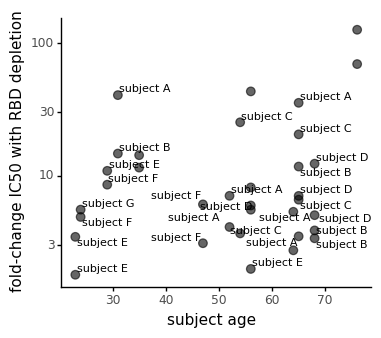

In [23]:
p = (ggplot((foldchange.dropna(subset=['sample'])
             [['serum', 'display_PID', 'fold_change', 'Age']]
             .drop_duplicates()
            )
           ) +
     aes('Age', 'fold_change') +
     geom_point(size=3, alpha=0.6) +
     scale_y_log10() +
     theme_classic() +
     theme(figure_size=(4, 3.5),
           ) +
     xlab('subject age') +
     ylab('fold-change IC50 with RBD depletion') +
     geom_text(label=foldchange['display_PID'],
               size=8, va='top', ha='right', alpha=1, nudge_x=-0.025, nudge_y=-0.025,
               show_legend=False,
               # see here for adjust_text: https://stackoverflow.com/a/57717833
               adjust_text={'avoid_text': True,
                            'avoid_points': False,
                            'avoid_self': True,
                            'expand_text': [1.1, 1.1]},
                   ) 
     ) 

_ = p.draw()

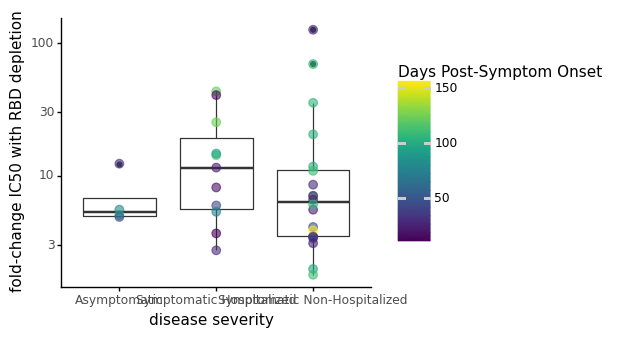

In [24]:
p = (ggplot((foldchange.dropna(subset=['sample'])
             [['serum', 'display_PID', 'Days Post-Symptom Onset', 'fold_change', 'Severity']]
             .drop_duplicates()
            )
           ) +
     aes('Severity', 'fold_change', color='Days Post-Symptom Onset') +
     geom_boxplot()+
     geom_point(size=3, alpha=0.6) +
     scale_y_log10() +
     theme_classic() +
     theme(figure_size=(4, 3.5),
           ) +
     xlab('disease severity') +
     ylab('fold-change IC50 with RBD depletion') 
     ) 

_ = p.draw()

Save `foldchange` file as Table S1.

In [25]:
foldchange.to_csv(f'{resultsdir}/rbd_depletion_foldchange_ic50.csv', index=False)

TableS1 = (foldchange.dropna(subset=['sample'])
           [['sample', 'Participant ID', 'display_PID', 
             'Sex', 'Age', 'Severity', 'Days Post-Symptom Onset','serum',
             'IC50_D614', 'NT50_D614',
             'NT50_pre','NT50_post','fold_change',
             'percent_RBD', 'post_ic50_bound', 'perc_RBD_str', 'mapped']]
           .drop_duplicates()
          )

TableS1['display_PID'] = pd.Categorical(TableS1['display_PID'], categories=PID_order, ordered=True)
TableS1 = TableS1.sort_values('display_PID')

print(TableS1.shape[0])
TableS1.to_csv(f'{resultsdir}/TableS1.csv', index=False)

35


## Titration ELISAs

### Read ELISA Titration Data

I first manipulated the data in R and made a new CSV file that we can read in now. Here I:
* Concatenate files together (if there are multiple)
* Remove samples as indicated in config file
* Replace serum names with `display_names`
* Change `dilution` to `dilution factor`
* Take 1/dilution factor to get the dilution (i.e., a 1:100 dilution is `dilution_factor==100` and `dilution==0.01`

In [26]:
titration_df = pd.DataFrame() # create empty data frame
elisa_samples_ignore = config['elisa_samples_ignore']

sample_information = pd.read_csv(config['sample_information'])

for f in config['elisa_input_files']:
    df = pd.read_csv(f)
    titration_df = titration_df.append(df)

# remove certain items from data frame before renaming (i.e., 23_d45 which was not fully depleted)
titration_df = (titration_df
        .query('serum not in @elisa_samples_ignore'))

titration_df = (titration_df
        .replace({'serum' : config['elisa_newnames']})
        .rename(columns={'dilution':'dilution_factor'})
        .assign(depleted= pd.Categorical(titration_df['depleted'], categories=['pre', 'post'], ordered=True),
                dilution=lambda x: 1/x['dilution_factor'],
                ab_serum = titration_df.apply(lambda x: 'antibody' 
                                                   if x['dilution_or_ugpermL']=="ugpermL" 
                                                   else 'serum',
                                                   axis=1)
               )
        .merge(sample_information, how='outer', left_on='serum', right_on='sample_name')
       )

print(titration_df.columns)
display(titration_df.head())  # display first few lines

Index(['serum', 'depleted', 'ligand', 'dilution_or_ugpermL', 'date',
       'dilution_factor', 'OD450', 'antibody_ugpermL', 'replicate',
       'log_dilution', 'dilution', 'ab_serum', 'sample', 'Participant ID',
       'Days Post-Symptom Onset', 'sample_name', 'display_PID', 'display_name',
       'depletion_elisas', 'depletion_neuts', 'sample_group', 'mapped',
       'experiment'],
      dtype='object')


,serum,depleted,ligand,dilution_or_ugpermL,date,dilution_factor,OD450,antibody_ugpermL,replicate,log_dilution,...,Participant ID,Days Post-Symptom Onset,sample_name,display_PID,display_name,depletion_elisas,depletion_neuts,sample_group,mapped,experiment
0,13_d15,pre,RBD,dilution,201020.0,100.0,3.4429,NaN,1.0,4.605170,...,13,15.0,13_d15,subject J,subject J (day 15),True,True,serum,True,expt_31
1,13_d15,pre,RBD,dilution,201020.0,300.0,2.6471,NaN,1.0,5.703782,...,13,15.0,13_d15,subject J,subject J (day 15),True,True,serum,True,expt_31
2,13_d15,pre,RBD,dilution,201020.0,900.0,1.8843,NaN,1.0,6.802395,...,13,15.0,13_d15,subject J,subject J (day 15),True,True,serum,True,expt_31
3,13_d15,pre,RBD,dilution,201020.0,2700.0,0.9066,NaN,1.0,7.901007,...,13,15.0,13_d15,subject J,subject J (day 15),True,True,serum,True,expt_31
4,13_d15,pre,RBD,dilution,201020.0,8100.0,0.2911,NaN,1.0,8.999619,...,13,15.0,13_d15,subject J,subject J (day 15),True,True,serum,True,expt_31


In [27]:
titration_df.query('serum=="23_d45 (re-depleted)"')

,serum,depleted,ligand,dilution_or_ugpermL,date,dilution_factor,OD450,antibody_ugpermL,replicate,log_dilution,...,Participant ID,Days Post-Symptom Onset,sample_name,display_PID,display_name,depletion_elisas,depletion_neuts,sample_group,mapped,experiment


### Plot spike and RBD ELISA curves on the same graph 

In [28]:
serum_order_descending = serum_order[::-1].tolist()+['pre-pandemic']
print(serum_order_descending)
print(PID_order)

['subject C (day 32)', 'subject C (day 104)', 'subject A (day 120)', 'subject A (day 21)', 'subject A (day 45)', 'subject G (day 18)', 'subject G (day 94)', 'subject E (day 104)', 'subject E (day 28)', 'subject J (day 121)', 'subject J (day 15)', 'subject K (day 103)', 'subject K (day 29)', 'subject B (day 113)', 'subject B (day 26)', 'subject L (day 35)', 'subject L (day 99)', 'subject I (day 102)', 'subject I (day 26)', 'subject P (day 109)', 'subject P (day 32)', 'subject F (day 115)', 'subject F (day 48)', 'subject Q (day 105)', 'subject Q (day 27)', 'subject R (day 79)', 'subject R (day 48)', 'subject M (day 26)', 'subject M (day 97)', 'subject D (day 76)', 'subject D (day 33)', 'subject H (day 152)', 'subject H (day 61)', 'subject N (day 32)', 'subject N (day 110)', 'pre-pandemic']
['subject C' 'subject A' 'subject G' 'subject E' 'subject J' 'subject K'
 'subject B' 'subject L' 'subject I' 'subject P' 'subject F' 'subject Q'
 'subject R' 'subject M' 'subject D' 'subject H' 'subje

In [29]:
def breakline(old_label):
    #m = re.fullmatch('(<prefix>) \((<suffix>)', old_label)
    if old_label=='pre-pandemic':
        return old_label
    else:
        m = re.fullmatch('(?P<prefix>[\w\d\s]+)\s\((?P<suffix>.+)', old_label)
        if not m:
            raise ValueError(f"Cannot match label {old_label}")
        #l = s.split("\s")
        prefix = m.group('prefix')
        suffix = m.group('suffix')
        return f"{prefix}\n({suffix}"

test_word = 'subject A (day 32)'
breakline(test_word)

'subject A\n(day 32)'

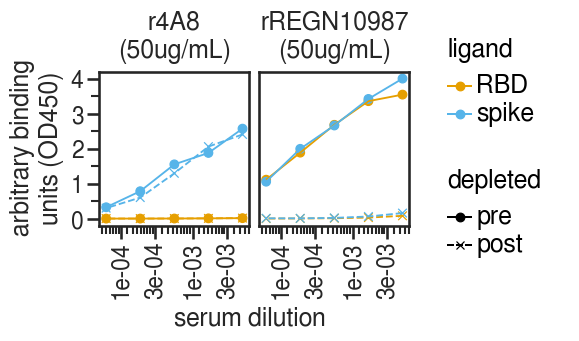

In [30]:
p = (
    ggplot(titration_df.query('sample_group=="antibody_control"').dropna(subset=['serum']),
           aes('dilution', 
               'OD450', 
               color='ligand',
               shape='depleted')) +
    geom_point(size=3) +
    geom_path(aes(color='ligand', linetype='depleted'), size=0.75) +
    scale_x_log10(name='serum dilution', labels=scientific_format(digits=0)) +
    facet_wrap('~ display_name', ncol=ncol, labeller=breakline) +
    theme(figure_size=(4, 2),
          axis_text_x=element_text(angle=90),
          subplots_adjust={'hspace':0.35},
          strip_margin=0.5,
          strip_background=element_blank()
         ) +
    scale_color_manual(values=CBPALETTE[1:]) +
    scale_shape_manual(values=['o', 'x']) +
    ylab('arbitrary binding\nunits (OD450)')
    )

_ = p.draw()
for extension in ['png', 'pdf', 'svg']:
    p.save(f'{resultsdir}/antibody_elisa_depletion.{extension}')

In [31]:
#titration_df[titration_df['display_name'].isnull()]
#titration_df.dropna(subset=['display_name'])

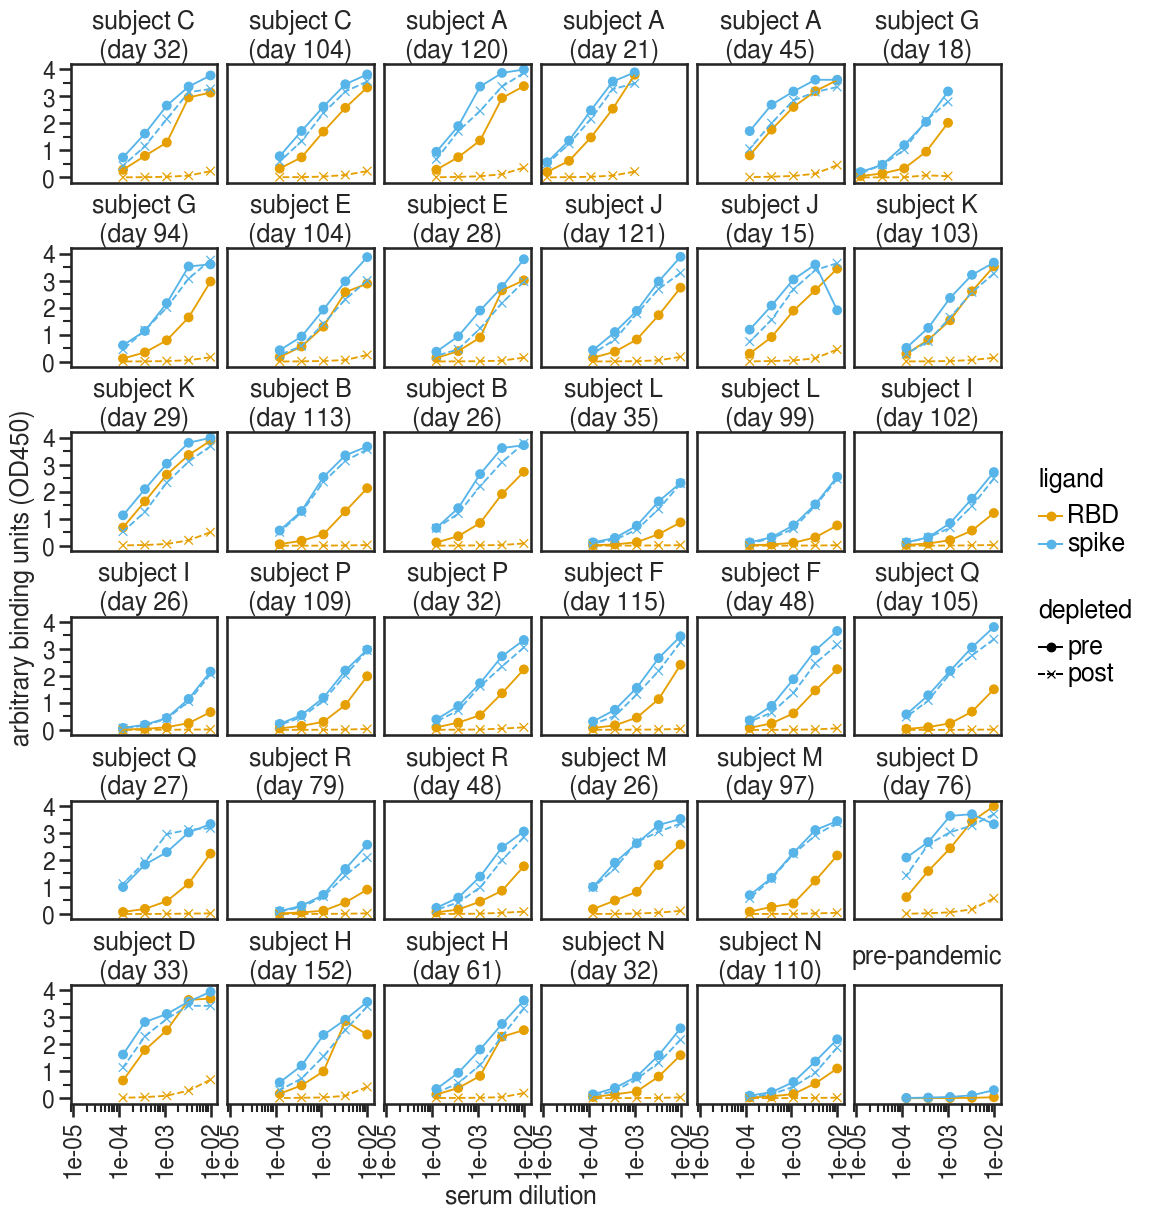

In [32]:
# remove second replicate for pre-pandemic serum because geom_segement doesn't work if you include it
# well maybe could use "group='replicate'"
df = titration_df.query('sample_group=="serum" & replicate!=2.0') 
df['display_name'] = pd.Categorical(df['display_name'], categories=serum_order_descending, ordered=True)

nconditions = df['display_name'].nunique()
ncol = np.minimum(6, nconditions)
nrow = math.ceil(nconditions / ncol)

p = (
    ggplot(df,
           aes('dilution', 
               'OD450', 
               color='ligand',
               shape='depleted')) +
    geom_point(size=3) +
    geom_path(aes(color='ligand', linetype='depleted'), size=0.75) +
    scale_x_log10(name='serum dilution', labels=scientific_format(digits=0)) +
    facet_wrap('~ display_name', ncol=ncol, labeller=breakline) +
    theme(figure_size=(2 * ncol, 2.25 * nrow),
          axis_text_x=element_text(angle=90),
          subplots_adjust={'hspace':0.55},
          strip_margin=0.35,
          strip_background=element_blank()
         ) +
    scale_color_manual(values=CBPALETTE[1:]) +
    scale_shape_manual(values=['o', 'x']) +
    ylab('arbitrary binding units (OD450)')
    )

_ = p.draw()

for extension in ['png', 'pdf', 'svg']:
    p.save(f'./{resultsdir}/serum_elisa_depletion.{extension}')

### Calculate area under curves (AUCs)

Calculate area under curve (AUC) for each ELISA. Note that these are areas calculated using a trapezoidal rule between the min and max dilutions with the x-axis being the natural log dilution factor.

The utility of these calculations pre-supposes that each sample has the same dilutions. 

**THIS IS NOT THE CASE FOR OUR DATA**

However, this is the case for the pre- and post-depletion samples for each seurm, which is what really matters. 

In [33]:
titration_df.columns

Index(['serum', 'depleted', 'ligand', 'dilution_or_ugpermL', 'date',
       'dilution_factor', 'OD450', 'antibody_ugpermL', 'replicate',
       'log_dilution', 'dilution', 'ab_serum', 'sample', 'Participant ID',
       'Days Post-Symptom Onset', 'sample_name', 'display_PID', 'display_name',
       'depletion_elisas', 'depletion_neuts', 'sample_group', 'mapped',
       'experiment'],
      dtype='object')

In [34]:
auc_df = (
    titration_df
    .query('sample_group=="serum"')
    .groupby(['display_name',
             'depleted',
             'ligand',
             'dilution_or_ugpermL',
             'date',
             'replicate',
             ])
    .apply(lambda g: sklearn.metrics.auc(g['log_dilution'], g['OD450']))
    .rename('AUC')
    .reset_index()
    )

auc_df.tail().round(3)

,display_name,depleted,ligand,dilution_or_ugpermL,date,replicate,AUC
139,subject R (day 48),post,spike,dilution,201029.0,1.0,5.385
140,subject R (day 79),pre,RBD,dilution,201108.0,1.0,1.166
141,subject R (day 79),pre,spike,dilution,201108.0,1.0,4.408
142,subject R (day 79),post,RBD,dilution,201108.0,1.0,0.020
143,subject R (day 79),post,spike,dilution,201108.0,1.0,3.747


### Get mean AUC for "background sample": the pre-pandemic 2017-2018 serum pool

In [35]:
auc_df.query('display_name=="pre-pandemic"').head()

,display_name,depleted,ligand,dilution_or_ugpermL,date,replicate,AUC
0,pre-pandemic,pre,RBD,dilution,201022.0,1.0,0.023291
1,pre-pandemic,pre,RBD,dilution,201022.0,2.0,0.060698
2,pre-pandemic,pre,spike,dilution,201022.0,1.0,0.343921
3,pre-pandemic,pre,spike,dilution,201022.0,2.0,0.384130


In [36]:
elisa_background_sample = config['elisa_background_sample']
background = (auc_df
              .query('display_name==@elisa_background_sample')
              .groupby(['ligand'])
              .aggregate({'AUC' : 'mean'})
              .reset_index()
             )

background

,ligand,AUC
0,RBD,0.041994
1,spike,0.364025


### Look at AUC pre- vs. post-depletion for each individual (same data as above, but with connecting lines)

The orange dashed line indicates the AUC of the pre-pandemic serum (2017-2018 pooled serum), which was not RBD depleted. 

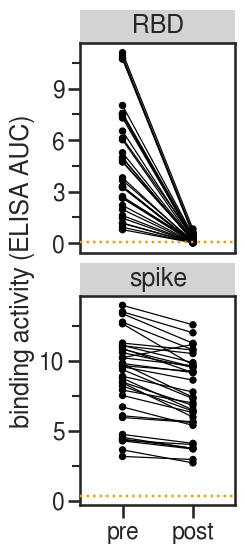

In [37]:
AUC_lines = (ggplot(auc_df
                    .query('display_name!=@elisa_background_sample'), 
                    aes(x='depleted', y='AUC', group='display_name')) +
                  geom_point(size=2) +
                  geom_line() +
                  facet_wrap('~ ligand', scales='free_y', ncol=1) +
                  theme(axis_text_x=element_text(angle=0, vjust=1, hjust=0.5),
                        axis_title_y=element_text(margin={'r': 12}),
                        figure_size=(2, 6), subplots_adjust={'wspace':0.25},
                        legend_entry_spacing=14) +
                  ylab('binding activity (ELISA AUC)') +
                  xlab('') +
                  # ggtitle('Change in AUC pre- vs. post-RBD absorption') +
             
             # add line for background defined by 2017-2018 serum pool
                  geom_hline(data=background,
                             mapping=aes(yintercept='AUC'),
                             color=CBPALETTE[1],
                             alpha=1,
                             size=1,
                             linetype='dotted',
                            ) 
                 )

_ = AUC_lines.draw()
for extension in ['png', 'pdf', 'svg']:
    AUC_lines.save(f'./{resultsdir}/AUC_lines.{extension}')

### Calculate fold-change AUC pre- vs. post-depletion.

We can also sort these values based on fold-change of spike AUC, as we probably expect the most RBD-targeting samples to have the greatest reduction in spike ELISA signal. 

In [38]:
foldchange_auc = (
    auc_df
    .assign(depleted=lambda x: x.depleted.astype(str)) #.columns = df1.columns.astype(list)
    .pivot_table(values='AUC', index=['display_name', 'ligand'], columns=['depleted'])
    .reset_index()
    .rename(columns={'post': 'post-depletion_auc', 'pre': 'pre-depletion_auc'})
    .assign(fold_change=lambda x: x['post-depletion_auc'] / x['pre-depletion_auc'],
            reciprocal_fold_change=lambda x: 1/x['fold_change']
           )
    )

#foldchange_auc.to_csv(f'{resultsdir}/rbd_depletion_foldchange_auc.csv', index=False)
foldchange_auc.head()

depleted,display_name,ligand,post-depletion_auc,pre-depletion_auc,fold_change,reciprocal_fold_change
0,pre-pandemic,RBD,NaN,0.041994,NaN,NaN
1,pre-pandemic,spike,NaN,0.364025,NaN,NaN
2,subject A (day 120),RBD,0.392809,7.570427,0.051887,19.272549
3,subject A (day 120),spike,10.782934,12.759970,0.845060,1.183349
4,subject A (day 21),RBD,0.223568,7.295884,0.030643,32.633907


In [39]:
foldchange_wider = (
    foldchange_auc
    .pivot_table(values='reciprocal_fold_change', index=['display_name'], columns=['ligand'])
    .reset_index()
    )

See if there is a relationship between decrease in spike binding with RBD depletion and age

In [40]:
foldchange_wider_meta = (foldchange_wider
             .merge((pd.read_csv(config['sample_information'])
                     [['sample', 'display_name', 'display_PID']]),
                    how='left',
                    left_on = 'display_name',
                    right_on='display_name')
             .merge((pd.read_csv(config['published_metadata'])
                     [['sample', 'Participant ID', 'Days Post-Symptom Onset', 'Age']]
                    ), 
                    how='left',
                    left_on = 'sample',
                    right_on='sample')
            )
foldchange_wider_meta.head()

,display_name,RBD,spike,sample,display_PID,Participant ID,Days Post-Symptom Onset,Age
0,subject A (day 120),19.272549,1.183349,96D33AAD,subject A,23,120.0,56.0
1,subject A (day 21),32.633907,1.111106,EDD7CFC8,subject A,23,21.0,56.0
2,subject A (day 45),22.143940,1.188261,331416C9,subject A,23,45.0,56.0
3,subject B (day 113),150.568519,1.059161,948FA9B9,subject B,1C,113.0,35.0
4,subject B (day 26),57.003767,1.131689,EBAD84C3,subject B,1C,26.0,35.0


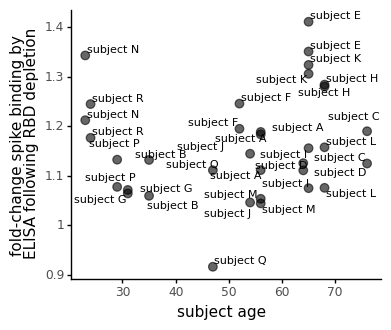

In [41]:
p = (ggplot(foldchange_wider_meta) +
     aes('Age', 'spike') +
     geom_point(size=3, alpha=0.6) +
     theme_classic() +
     theme(figure_size=(4, 3.5)) +
     xlab('subject age') +
     ylab('fold-change spike binding by \nELISA following RBD depletion') +
     geom_text(label=foldchange_wider_meta['display_PID'],
               size=8, va='top', ha='right', alpha=1, nudge_x=-0.025, nudge_y=-0.025,
               show_legend=False,
               # see here for adjust_text: https://stackoverflow.com/a/57717833
               adjust_text={'avoid_text': True,
                            'avoid_points': False,
                            'avoid_self': True,
                            'expand_text': [1.1, 1.1]},
                   ) 
     ) 

_ = p.draw()

# plotfile = f'./{resultsdir}/age_v_foldchange_spike_ELISA.pdf'
# print(f"Saving to {plotfile}")
# p.save(plotfile, verbose=False)

From a quick by-eye comparison between this sorted list (by fold-change spike AUC) and the fold-change IC50 in neutralizzation assays, there is little relationship between these two. 
So I am not going to worry about this anymore. 
For reference, the samples that had the greatest reduction in NT50 (or increase in IC50) following depletion were:
1. 24C_d104
2. 25_d18
3. 22C_d104
4. 1C_d26
5. 24C_d32
6. 25_d94
7. 1C_d113

For ELISAs, we see a very small decrease in spike AUC following depletion for 24C and 25 samples in particular.
So, I am not going to worry about the ELISA signal anymore and just take the ELISAs as a test of whether the depletion worked or not. 

In [42]:
foldchange.head()

,serum,post-depletion_ic50,pre-depletion_ic50,fold_change,percent_RBD,NT50_pre,NT50_post,post_ic50_bound,perc_RBD_str,depletion,...,experiment,ic50_is_bound,Sex,Age,Severity,IC50_D614,NT50_D614,logNT50_D614,logNT50_G614,max_fc
0,r4A8 (50ug/mL),0.000069,0.000132,0.519645,-92,7576.430381,14580.001196,True,>-92%,pre-depletion,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,8.932797,NaN
1,r4A8 (50ug/mL),0.000069,0.000132,0.519645,-92,7576.430381,14580.001196,True,>-92%,post-depletion,...,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,8.932797,NaN
2,rREGN10987 (25ug/mL),0.010000,0.000397,25.212923,96,2521.292258,100.000000,True,>96%,pre-depletion,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,7.832527,NaN
3,rREGN10987 (25ug/mL),0.010000,0.000397,25.212923,96,2521.292258,100.000000,True,>96%,post-depletion,...,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,7.832527,NaN
4,rREGN10987 (50ug/mL),0.005000,0.000215,23.252801,95,4650.560175,200.000000,True,>95%,pre-depletion,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,8.444743,NaN


One final analysis: what if look at the decrease in spike binding vs. neutralization following RBD depletion (I already know this is not going to be informative)

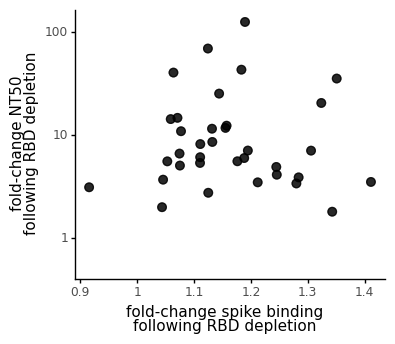

In [43]:
p = (ggplot(foldchange.merge(foldchange_wider, how='left', left_on='serum', right_on='display_name'
           )) +
     aes('spike', 'fold_change') +
     geom_point(size=3, alpha=0.6) +
     scale_y_log10() +
     theme_classic() +
     theme(figure_size=(4, 3.5),
           ) +
     xlab('fold-change spike binding\nfollowing RBD depletion') +
     ylab('fold-change NT50\nfollowing RBD depletion') 
     #+
#      geom_text(label=foldchange['display_PID'],
#                size=8, va='top', ha='right', alpha=1, nudge_x=-0.025, nudge_y=-0.025,
#                show_legend=False,
#                # see here for adjust_text: https://stackoverflow.com/a/57717833
#                adjust_text={'avoid_text': True,
#                             'avoid_points': False,
#                             'avoid_self': True,
#                             'expand_text': [1.1, 1.1]},
#                    ) 
     ) 

_ = p.draw()

# plotfile = f'./{resultsdir}/spike_v_foldchange.pdf'
# print(f"Saving to {plotfile}")
# p.save(plotfile, verbose=False)

In [44]:
!jupyter nbconvert rbd_depletions.ipynb --to html
!jupyter nbconvert rbd_depletions.ipynb --to markdown

[NbConvertApp] Converting notebook rbd_depletions.ipynb to html
[NbConvertApp] Writing 2375826 bytes to rbd_depletions.html
[NbConvertApp] Converting notebook rbd_depletions.ipynb to markdown
[NbConvertApp] Support files will be in rbd_depletions_files/
[NbConvertApp] Making directory rbd_depletions_files
[NbConvertApp] Making directory rbd_depletions_files
[NbConvertApp] Making directory rbd_depletions_files
[NbConvertApp] Making directory rbd_depletions_files
[NbConvertApp] Making directory rbd_depletions_files
[NbConvertApp] Making directory rbd_depletions_files
[NbConvertApp] Making directory rbd_depletions_files
[NbConvertApp] Making directory rbd_depletions_files
[NbConvertApp] Making directory rbd_depletions_files
[NbConvertApp] Making directory rbd_depletions_files
[NbConvertApp] Making directory rbd_depletions_files
[NbConvertApp] Making directory rbd_depletions_files
[NbConvertApp] Making directory rbd_depletions_files
[NbConvertApp] Making directory rbd_depletions_files
[NbC